# RNN2

### Source

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

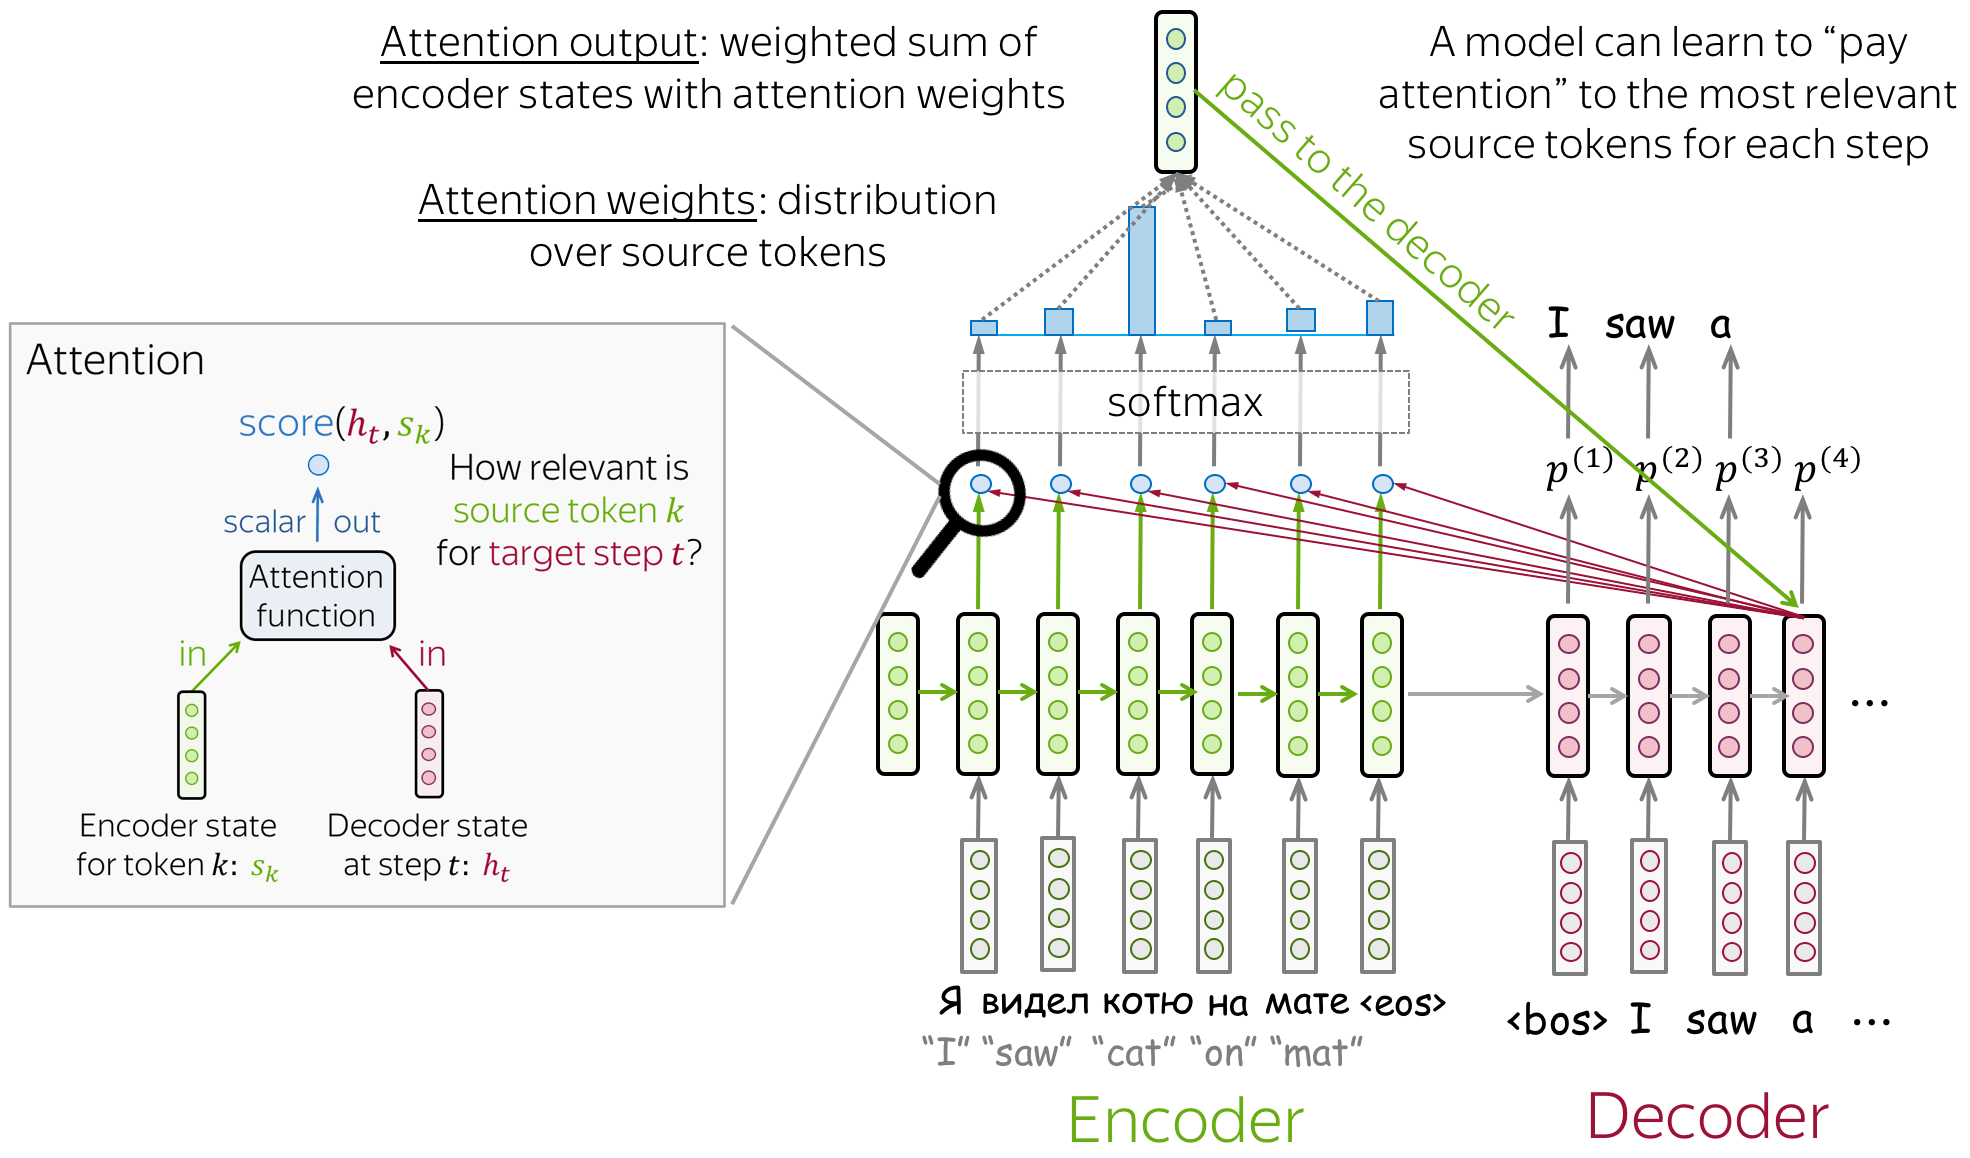

In [2]:
%matplotlib inline
from IPython.display import Image
Image("./seq2seq.png")
# https://stackoverflow.com/questions/61598771/pytorch-squeeze-and-unsqueeze

## Data preparation

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.。!?])", r" \1", s)
    s = re.sub(r"[.。]+", r" ", s)
    return s.strip()

In [4]:
re.sub(r"。", r" ", "汉语。")

'汉语 '

In [6]:
lines = open('%s-%s.txt' % ('eng', 'cmn'), encoding='utf-8').\
        read().strip().split('\n')
lines

['Hi.\t嗨。\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #891077 (Martha)',
 'Hi.\t你好。\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4857568 (musclegirlxyp)',
 'Run.\t你用跑的。\tCC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #3748344 (egg0073)',
 'Stop!\t住手！\tCC-BY 2.0 (France) Attribution: tatoeba.org #448320 (CM) & #448321 (GlossaMatik)',
 'Wait!\t等等！\tCC-BY 2.0 (France) Attribution: tatoeba.org #1744314 (belgavox) & #4970122 (wzhd)',
 'Wait!\t等一下！\tCC-BY 2.0 (France) Attribution: tatoeba.org #1744314 (belgavox) & #5092613 (mirrorvan)',
 'Begin.\t开始！\tCC-BY 2.0 (France) Attribution: tatoeba.org #6102432 (mailohilohi) & #5094852 (Jin_Dehong)',
 'Hello!\t你好。\tCC-BY 2.0 (France) Attribution: tatoeba.org #373330 (CK) & #4857568 (musclegirlxyp)',
 'I try.\t我试试。\tCC-BY 2.0 (France) Attribution: tatoeba.org #20776 (CK) & #8870261 (will66)',
 'I won!\t我赢了。\tCC-BY 2.0 (France) Attribution: tatoeba.org #2005192 (CK) & #5102367 (mirrorvan)',
 'Oh no!\

In [9]:
# conda install -c conda-forge jieba
import jieba

In [9]:
' '.join(jieba.cut("我来到福建厦门大学", cut_all=True))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Dell\AppData\Local\Temp\jieba.cache
Loading model cost 0.519 seconds.
Prefix dict has been built successfully.


'我 来到 福建 福建厦门 厦门 厦门大学 大学'

In [10]:
' '.join(jieba.cut("我来到福建厦门大学", cut_all=False))

'我 来到 福建 厦门大学'

In [7]:
def readEngCMN():
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('eng-cmn.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[0:2]] for l in lines]
    pair0 = [p[0] for p in pairs]
    pair1 = [' '.join(jieba.cut(p[1])) for p in pairs]
    pairs = list(zip(pair0, pair1))
    input_lang = Lang('eng')
    output_lang = Lang('cmn')

    return input_lang, output_lang, pairs

### Get data

In [10]:
input_lang, output_lang, pairs = readEngCMN()

Reading lines...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\13655\AppData\Local\Temp\jieba.cache
Loading model cost 0.456 seconds.
Prefix dict has been built successfully.


In [27]:
MAX_LENGTH = 500

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(pairs):
    return len(pairs[0].split(' ')) < MAX_LENGTH and \
        len(pairs[1].split(' ')) < MAX_LENGTH and \
        pairs[0].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [12]:
def prepareData():
    input_lang, output_lang, pairs = readEngCMN()
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData()
print(random.choice(pairs))

Reading lines...
Read 29668 sentence pairs
Trimmed to 734 sentence pairs
Counting words...
Counted words:
eng 844
cmn 1139
('he is a tennis player', '他 是 个 网球 球手')


In [13]:
from itertools import islice
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))
len(output_lang.word2count)
take(5, output_lang.word2index.items())

[('我', 2), ('冷', 3), ('吃', 4), ('飽', 5), ('了', 6)]

## Encoder

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden
# https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

In [29]:
hidden_size = 128
batch_size = 32

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

## Decoder

In [18]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

## Attention decoder

In [19]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys) # batch matrix multiplication

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super().__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

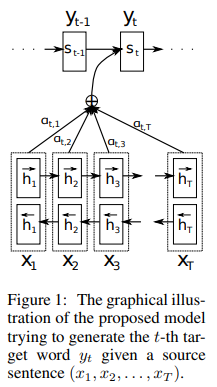

In [7]:
Image("./Bahdanau.png")

$$c_i=\sum_{j=1}^{T_x}\alpha_{ij}h_j$$

$$\alpha_{ij}=\dfrac{\exp\{e_{ij}\}}{\sum_{k=1}^{T_x}\exp\{e_{ik}\}}$$

$$e_{ij}=a(s_{i-1},h_j)$$

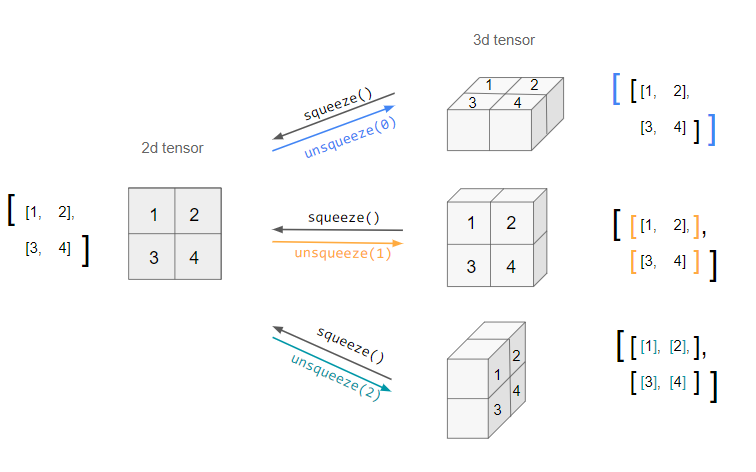

In [5]:
Image("./squeeze.png")
# https://stackoverflow.com/questions/61598771/pytorch-squeeze-and-unsqueeze

## Training data

In [20]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [21]:
indexesFromSentence(output_lang, pairs[1][1])

[2, 4, 5, 6]

In [22]:
pairs[1][1]

'我 吃 飽 了'

In [23]:
take(8, output_lang.word2index)

['我', '冷', '吃', '飽', '了', '沒事', '生病', '个子']

In [24]:
def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData()

    n = len(pairs)
    input_idxs = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_idxs = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (x, y) in enumerate(pairs):
        x_idx = indexesFromSentence(input_lang, x)
        x_idx.append(EOS_token)
        input_idxs[idx, :len(x_idx)] = x_idx

        y_idx = indexesFromSentence(output_lang, y)
        y_idx.append(EOS_token)
        target_idxs[idx, :len(y_idx)] = y_idx

    train_data = TensorDataset(torch.LongTensor(input_idxs).to(device),
                               torch.LongTensor(target_idxs).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

## Training

In [25]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [30]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.01)
criterion = nn.NLLLoss()
loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

In [31]:
for data in train_dataloader:
    input_tensor, target_tensor = data

In [32]:
input_tensor

tensor([[  9,  10,  78,  ...,   0,   0,   0],
        [ 26,  10, 183,  ...,   0,   0,   0],
        [  2,   3,  11,  ...,   0,   0,   0],
        ...,
        [  9,  10, 288,  ...,   0,   0,   0],
        [ 29,  30,  31,  ...,   0,   0,   0],
        [  9,  10,  38,  ...,   0,   0,   0]])

In [33]:
target_tensor

tensor([[765, 507, 508,  ...,   0,   0,   0],
        [ 33, 585, 236,  ...,   0,   0,   0],
        [  2,  12,  73,  ...,   0,   0,   0],
        ...,
        [656, 799, 800,  ...,   0,   0,   0],
        [ 37,  38,  39,  ...,   0,   0,   0],
        [ 11,  47,  48,  ...,   0,   0,   0]])

In [34]:
outen, hidden = encoder(input_tensor)

In [35]:
hidden.shape

torch.Size([1, 30, 128])

In [36]:
outen.shape

torch.Size([30, 500, 128])

In [124]:
hidden[0]

tensor([[ 0.0493, -1.0000, -0.6704,  ...,  1.0000,  1.0000, -1.0000],
        [ 0.1836, -1.0000, -0.8580,  ...,  1.0000,  0.9999, -1.0000],
        [ 0.5215, -1.0000, -0.7045,  ...,  1.0000,  0.9999, -1.0000],
        ...,
        [ 0.2677, -1.0000, -0.9496,  ...,  1.0000,  0.9999, -1.0000],
        [-0.9848, -1.0000, -0.8438,  ...,  1.0000,  0.9999, -1.0000],
        [ 0.4000, -1.0000, -0.8910,  ...,  0.9999,  0.9996, -1.0000]],
       grad_fn=<SelectBackward0>)

In [125]:
outen[:, -1]

tensor([[ 0.0493, -1.0000, -0.6704,  ...,  1.0000,  1.0000, -1.0000],
        [ 0.1836, -1.0000, -0.8580,  ...,  1.0000,  0.9999, -1.0000],
        [ 0.5215, -1.0000, -0.7045,  ...,  1.0000,  0.9999, -1.0000],
        ...,
        [ 0.2677, -1.0000, -0.9496,  ...,  1.0000,  0.9999, -1.0000],
        [-0.9848, -1.0000, -0.8438,  ...,  1.0000,  0.9999, -1.0000],
        [ 0.4000, -1.0000, -0.8910,  ...,  0.9999,  0.9996, -1.0000]],
       grad_fn=<SelectBackward0>)

In [58]:
decoder_outputs.shape

torch.Size([22, 10, 1048])

In [52]:
decoder_outputs, _, _ = decoder(outen, hidden, target_tensor)

In [56]:
see = decoder_outputs.view(-1, decoder_outputs.size(-1))
see.shape

torch.Size([220, 1048])

In [55]:
see = target_tensor.view(-1)
see.shape

torch.Size([220])

In [37]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [38]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [39]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [40]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

Reading lines...
Read 29668 sentence pairs
Trimmed to 734 sentence pairs
Counting words...
Counted words:
eng 844
cmn 1139


In [41]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 20, print_every=5, plot_every=5)

Reading lines...
Read 29668 sentence pairs
Trimmed to 734 sentence pairs
Counting words...
Counted words:
eng 844
cmn 1139


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    input_tensor = tensorFromSentence(input_lang, "i am good")

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

    _, topi = decoder_outputs.topk(1)
    decoded_ids = topi.squeeze()

    decoded_words = []
    for idx in decoded_ids:
        if idx.item() == EOS_token:
            decoded_words.append('<EOS>')
            break
        decoded_words.append(output_lang.index2word[idx.item()])

decoded_words

### Regular expressions

https://docs.python.org/3/library/re.html

In [ ]:
# look around
print(re.search(r"q(?=u)i", 'quit'))
print(re.search(r"[a-zA-Z0-9_]", "my name"))